# Classifying cat vocalization spectrograms

This Python notebook demonstrates how to use [Tensorflow](https://www.tensorflow.org/) to build and train a [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model to classify [spectrograms](https://en.wikipedia.org/wiki/Spectrogram) of recorded cat vocalizations.

- Step 1: Download sample training data
- Step 2: View sample training images (spectrograms)
- Step 3: Create a `tf.data.Dataset` for training and one for validation
- Step 4: Build and train a model
- Step 5: View training progress
- Step 6: Download some test images
- Step 7: Calssify test images

## Step 1: Download sample training data

Training data is available here: [training data](https://github.com/spackows/CASCON-2018_Analyzing_images/tree/master/cat-translator/training-data)

The training data contains recordings of a cat meowing in two scenarios:
- Wanting to be fed (class: "feedme")
- Wanting to go through a closed door (class: "opendoor")

\*The training set is small and the model simple.  The intention of this notebook is just to demonstrate the steps of the process.

In [1]:
feedme_url = "https://github.com/spackows/CASCON-2018_Analyzing_images/blob/master/cat-translator/training-data/cat-feedme.zip?raw=true"
feedme_dir = "training-data/feedme"

opendoor_dir = "training-data/opendoor"
opendoor_url = "https://github.com/spackows/CASCON-2018_Analyzing_images/blob/master/cat-translator/training-data/cat-opendoor.zip?raw=true"

In [6]:
import urllib
import zipfile

def downloadTrainingData( url, dir ):
    zip_path, _ = urllib.request.urlretrieve( url )
    with zipfile.ZipFile( zip_path, "r" ) as f:
        f.extractall( dir )

In [7]:
downloadTrainingData( feedme_url, feedme_dir )
!ls training-data/feedme

cat-food-training_01.png  cat-food-training_08.png  cat-food-training_15.png
cat-food-training_02.png  cat-food-training_09.png  cat-food-training_16.png
cat-food-training_03.png  cat-food-training_10.png  cat-food-training_17.png
cat-food-training_04.png  cat-food-training_11.png  cat-food-training_18.png
cat-food-training_05.png  cat-food-training_12.png  cat-food-training_19.png
cat-food-training_06.png  cat-food-training_13.png
cat-food-training_07.png  cat-food-training_14.png


In [8]:
downloadTrainingData( opendoor_url, opendoor_dir )
!ls training-data/opendoor

cat-door-training_01.png  cat-door-training_06.png  cat-door-training_11.png
cat-door-training_02.png  cat-door-training_07.png  cat-door-training_12.png
cat-door-training_03.png  cat-door-training_08.png  cat-door-training_13.png
cat-door-training_04.png  cat-door-training_09.png  cat-door-training_14.png
cat-door-training_05.png  cat-door-training_10.png  cat-door-training_15.png


height: 224
width: 224


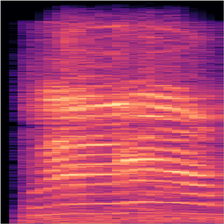

In [9]:
import PIL.Image

img = PIL.Image.open( "training-data/feedme/cat-food-training_01.png")
img_height = img.height
img_width = img.width
print( "height: " + str( img_height ) + "\nwidth: " + str( img_width ) )
img

## Step 2: View sample training images (spectrograms)
In these spectrograms, information about the sound the cat is making is encoded in three ways:
- **Time:** Moves forward from left to rigth
- **Pitch:** Sounds of lower pitch are displayed at the bottom, and higher-pitch sounds are at the top
- **Volume:** The quiet sounds are represented by dark colors, and louder sounds are represented by bright, yellow colors

Armed with this information, you can see in the sample spectrograms from the training data that the "feedme" meows are higher pitched and louder than the "open this door" meows.

In [10]:
import matplotlib.pyplot as plt

samples = [
    "training-data/feedme/cat-food-training_01.png",
    "training-data/feedme/cat-food-training_02.png",
    "training-data/feedme/cat-food-training_03.png",
    "training-data/feedme/cat-food-training_04.png",
    "training-data/opendoor/cat-door-training_01.png",
    "training-data/opendoor/cat-door-training_02.png",
    "training-data/opendoor/cat-door-training_03.png",
    "training-data/opendoor/cat-door-training_04.png"
]

def showSamples( class_name ):
    fig, axs = plt.subplots( 1, 4, figsize = ( 15, 5 ) )
    index_shift = 0 if "feedme" == class_name else 4
    for i in range( 4 ):
        axs[i].imshow( PIL.Image.open( samples[ i + index_shift ] ) )
        axs[i].set_xticks( [] )
        axs[i].set_yticks( [] )
    print( class_name )

feedme


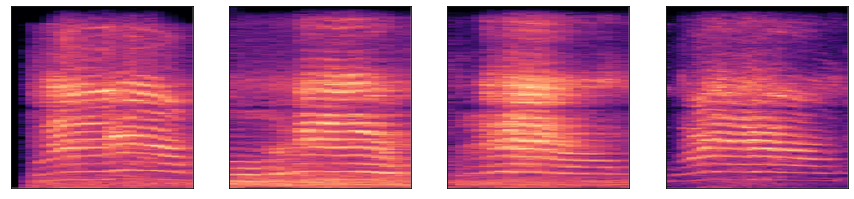

In [11]:
showSamples( "feedme" )

opendoor


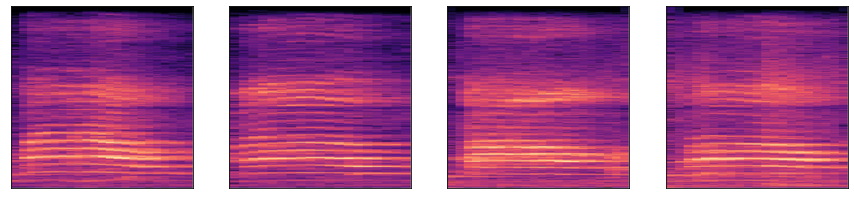

In [12]:
showSamples( "opendoor" )

## Step 3: Create a `tf.data.Dataset` for training and one for validation

The steps for using Tensorflow are the same as in the image classification tutorial on the Tensorflow website.

See:
- [Image classification tutorial](https://www.tensorflow.org/tutorials/images/classification)
- [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

In [24]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = "training-data",
    labels = "inferred",
    label_mode = "binary",
    class_names = [ "feedme", "opendoor" ],
    batch_size = 1,
    image_size = ( img_height, img_height ),
    seed = 123,
    validation_split = 0.2,
    subset = "training" )

Found 34 files belonging to 2 classes.
Using 28 files for training.


In [25]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = "training-data",
    labels = "inferred",
    label_mode = "binary",
    class_names = [ "feedme", "opendoor" ],
    batch_size = 1,
    image_size = ( img_height, img_height ),
    seed = 123,
    validation_split = 0.2,
    subset = "validation" )

Found 34 files belonging to 2 classes.
Using 6 files for validation.


## Step 4: Build and train a model

In [26]:
# https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance
#
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch( buffer_size = AUTOTUNE )
val_ds = val_ds.cache().prefetch( buffer_size = AUTOTUNE )

In [27]:
# https://www.tensorflow.org/guide/keras/sequential_model
#
class_names = [ "feedme", "opendoor" ]
num_classes = len( class_names )

model = Sequential([
    layers.Rescaling( 1./255, input_shape=( img_height, img_width, 3 ) ),
    layers.Conv2D( 16, 3, padding = 'same', activation = 'relu' ),
    layers.MaxPooling2D(),
    layers.Conv2D( 32, 3, padding = 'same', activation = 'relu' ),
    layers.MaxPooling2D(),
    layers.Conv2D( 64, 3, padding = 'same', activation = 'relu' ),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense( 128, activation = 'relu' ),
    layers.Dense( num_classes )
])

In [28]:
# https://www.tensorflow.org/tutorials/images/classification#compile_the_model
#
model.compile( optimizer = "adam",
               loss = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True ),
               metrics = [ "accuracy" ] )

In [29]:
# https://www.tensorflow.org/tutorials/images/classification#train_the_model
#
epochs = 10
history = model.fit( train_ds, validation_data = val_ds, epochs = epochs )

Epoch 1/10
28/28 [==============================] - 3s 86ms/step - loss: 0.9651 - accuracy: 0.5714 - val_loss: 0.6556 - val_accuracy: 0.5000
Epoch 2/10
28/28 [==============================] - 2s 78ms/step - loss: 0.5840 - accuracy: 0.8214 - val_loss: 1.1380 - val_accuracy: 0.5000
Epoch 3/10
28/28 [==============================] - 2s 78ms/step - loss: 0.7835 - accuracy: 0.6786 - val_loss: 0.6543 - val_accuracy: 0.5000
Epoch 4/10
28/28 [==============================] - 2s 77ms/step - loss: 0.5428 - accuracy: 0.7500 - val_loss: 0.9061 - val_accuracy: 0.6667
Epoch 5/10
28/28 [==============================] - 2s 78ms/step - loss: 0.4950 - accuracy: 0.8929 - val_loss: 0.5160 - val_accuracy: 0.8333
Epoch 6/10
28/28 [==============================] - 2s 79ms/step - loss: 0.4948 - accuracy: 0.8214 - val_loss: 0.3801 - val_accuracy: 1.0000
Epoch 7/10
28/28 [==============================] - 2s 76ms/step - loss: 0.1677 - accuracy: 0.9643 - val_loss: 0.2150 - val_accuracy: 0.8333
Epoch 8/10
28

## Step 5: View training progress

Visually inspecting the way training progressed can tell you at a glance if there were major problems with the training (eg. [overfitting](https://www.tensorflow.org/tutorials/images/classification#overfitting)).

\*Because there are so few images in the training data, it's possible for training to be irratic.  If your results are poor, rerun steps 3, 4, and 5 to see if the random distribution in the training data and validation data works better. Or try running more epochs.

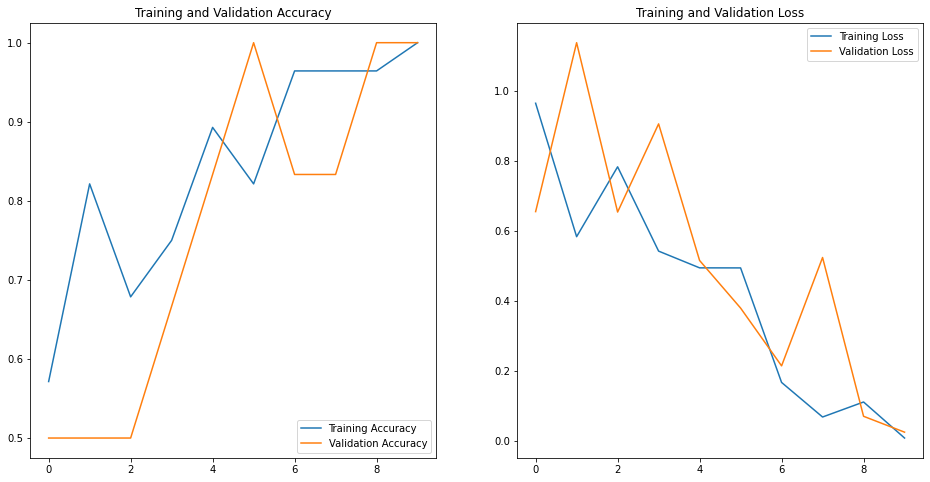

In [30]:
# https://www.tensorflow.org/tutorials/images/classification#visualize_training_results
#
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure( figsize = ( 16, 8 ) )
plt.subplot( 1, 2, 1 )
plt.plot( epochs_range, acc, label = 'Training Accuracy')
plt.plot( epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend( loc = 'lower right' )
plt.title( 'Training and Validation Accuracy')

plt.subplot( 1, 2, 2 )
plt.plot( epochs_range, loss, label = 'Training Loss')
plt.plot( epochs_range, val_loss, label = 'Validation Loss')
plt.legend( loc = 'upper right' )
plt.title( 'Training and Validation Loss' )
plt.show()

## Step 6: Download some test images

Test images are available here: [test images](https://github.com/spackows/CASCON-2018_Analyzing_images/tree/master/cat-translator/test-data)

In [33]:
import urllib.request

test_01_file = "cat-food-test_01.png"
test_02_file = "cat-food-test_02.png"
test_03_file = "cat-door-test_01.png"
test_04_file = "cat-door-test_02.png"

test_01_url = "https://raw.githubusercontent.com/spackows/CASCON-2018_Analyzing_images/master/cat-translator/test-data/" + test_01_file
test_02_url = "https://raw.githubusercontent.com/spackows/CASCON-2018_Analyzing_images/master/cat-translator/test-data/" + test_02_file
test_03_url = "https://raw.githubusercontent.com/spackows/CASCON-2018_Analyzing_images/master/cat-translator/test-data/" + test_03_file
test_04_url = "https://raw.githubusercontent.com/spackows/CASCON-2018_Analyzing_images/master/cat-translator/test-data/" + test_04_file

urllib.request.urlretrieve( test_01_url, test_01_file )
urllib.request.urlretrieve( test_02_url, test_02_file )
urllib.request.urlretrieve( test_03_url, test_03_file )
urllib.request.urlretrieve( test_04_url, test_04_file )

!ls

cat-door-test_01.png  cat-food-test_01.png  training-data
cat-door-test_02.png  cat-food-test_02.png


## Step 7: Classify test images

In [42]:
import numpy as np

def classifyImage( file_name ):
    img = tf.keras.utils.load_img( file_name, target_size = ( img_height, img_width ) )
    img_array = tf.keras.utils.img_to_array( img )
    img_array = tf.expand_dims( img_array, 0 )
    predictions = model.predict( img_array )
    score = tf.nn.softmax( predictions[0] )
    print( "Image: " + file_name + "\n" +
           "Predicted class: " + str( class_names[ np.argmax( score ) ] ) + "\n" +
           "Confidence: " + str( round( 100 * np.max( score ), 3 ) ) + "%" )

Image: cat-food-test_01.png
Predicted class: feedme
Confidence: 99.996%


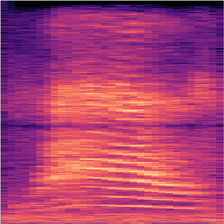

In [43]:
classifyImage( test_01_file )
PIL.Image.open( test_01_file )

Image: cat-food-test_02.png
Predicted class: feedme
Confidence: 99.984%


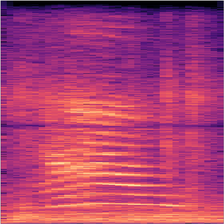

In [44]:
classifyImage( test_02_file )
PIL.Image.open( test_02_file )

Image: cat-door-test_01.png
Predicted class: opendoor
Confidence: 99.817%


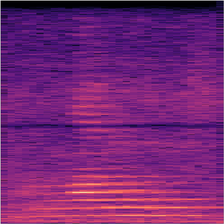

In [45]:
classifyImage( test_03_file )
PIL.Image.open( test_03_file )

Image: cat-door-test_02.png
Predicted class: opendoor
Confidence: 99.969%


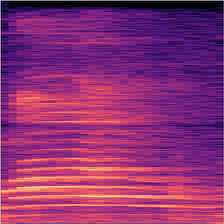

In [46]:
classifyImage( test_04_file )
PIL.Image.open( test_04_file )